In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [4]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/nCars_train_EST_trilinear_", transform=transforms)
test_data = NCarsImageDataset("./Datasety/nCars_test_EST_trilinear_", transform=transforms)



In [5]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
from torch import nn

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 80, start_factor=1.0, end_factor=0.01, total_iters=70):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2__128x128_pretrained_aug_correct_trilinear.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [8]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 12).to("cuda")


In [9]:
model_resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kern

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
print(model)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

### Copy of a weights

In [12]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Con

In [13]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8192e-01]

In [14]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

In [15]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90) #, learning_rate=5e-4

  0%|          | 0/482 [00:00<?, ?it/s]

100%|██████████| 482/482 [02:07<00:00,  3.78it/s]


Epoch [1/120], Step [482/482], Loss: 0.7111, Accuracy: 0.4892
Accuracy of the network: 48.64645056349483 Loss: 0.6924216647573563%


100%|██████████| 482/482 [01:58<00:00,  4.07it/s]


Epoch [2/120], Step [482/482], Loss: 0.6966, Accuracy: 0.4854
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [02:03<00:00,  3.91it/s]


Epoch [3/120], Step [482/482], Loss: 0.7042, Accuracy: 0.4840
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [02:02<00:00,  3.95it/s]


Epoch [4/120], Step [482/482], Loss: 0.6956, Accuracy: 0.4856
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [02:01<00:00,  3.96it/s]


Epoch [5/120], Step [482/482], Loss: 0.7028, Accuracy: 0.4881
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [02:08<00:00,  3.74it/s]


Epoch [6/120], Step [482/482], Loss: 0.6947, Accuracy: 0.4866
Accuracy of the network: 48.925293365864995 Loss: 0.6930264230111275%


100%|██████████| 482/482 [02:13<00:00,  3.60it/s]


Epoch [7/120], Step [482/482], Loss: 0.6947, Accuracy: 0.4887
Accuracy of the network: 48.925293365864995 Loss: 0.679570389946154%


100%|██████████| 482/482 [02:18<00:00,  3.49it/s]


Epoch [8/120], Step [482/482], Loss: 0.6840, Accuracy: 0.4857
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [02:14<00:00,  3.58it/s]


Epoch [9/120], Step [482/482], Loss: 0.6962, Accuracy: 0.4847
Accuracy of the network: 48.82072731497618 Loss: 0.6931634924225648%


100%|██████████| 482/482 [01:28<00:00,  5.44it/s]


Epoch [10/120], Step [482/482], Loss: 0.6745, Accuracy: 0.5277
Accuracy of the network: 48.925293365864995 Loss: 0.6527651993758616%


100%|██████████| 482/482 [01:56<00:00,  4.13it/s]


Epoch [11/120], Step [482/482], Loss: 0.5314, Accuracy: 0.7179
Accuracy of the network: 71.89496921110724 Loss: 0.5988620398877722%


100%|██████████| 482/482 [02:06<00:00,  3.82it/s]


Epoch [12/120], Step [482/482], Loss: 0.4344, Accuracy: 0.8171
Accuracy of the network: 78.33159056581852 Loss: 0.4729447332678231%


100%|██████████| 482/482 [01:51<00:00,  4.32it/s]


Epoch [13/120], Step [482/482], Loss: 0.4088, Accuracy: 0.8288
Accuracy of the network: 79.83037062855816 Loss: 0.4561340212268014%


100%|██████████| 482/482 [02:09<00:00,  3.71it/s]


Epoch [14/120], Step [482/482], Loss: 0.3642, Accuracy: 0.8570
Accuracy of the network: 80.9457418380388 Loss: 0.4364160280466966%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [15/120], Step [482/482], Loss: 0.3715, Accuracy: 0.8540
Accuracy of the network: 79.50505402579296 Loss: 0.46376964826566136%


100%|██████████| 482/482 [02:04<00:00,  3.88it/s]


Epoch [16/120], Step [482/482], Loss: 0.3510, Accuracy: 0.8632
Accuracy of the network: 82.35157429998839 Loss: 0.4213715623302531%


100%|██████████| 482/482 [02:41<00:00,  2.98it/s]


Epoch [17/120], Step [482/482], Loss: 0.3553, Accuracy: 0.8583
Accuracy of the network: 76.22865109794354 Loss: 0.5073544885478498%


100%|██████████| 482/482 [02:00<00:00,  3.99it/s]


Epoch [18/120], Step [482/482], Loss: 0.3443, Accuracy: 0.8684
Accuracy of the network: 80.75984663645869 Loss: 0.44149989343930357%


100%|██████████| 482/482 [02:01<00:00,  3.97it/s]


Epoch [19/120], Step [482/482], Loss: 0.3358, Accuracy: 0.8739
Accuracy of the network: 76.33321714883235 Loss: 0.5251499061026095%


100%|██████████| 482/482 [02:01<00:00,  3.98it/s]


Epoch [20/120], Step [482/482], Loss: 0.3423, Accuracy: 0.8671
Accuracy of the network: 80.0859765307308 Loss: 0.4490889221097457%


100%|██████████| 482/482 [02:01<00:00,  3.97it/s]


Epoch [21/120], Step [482/482], Loss: 0.3404, Accuracy: 0.8693
Accuracy of the network: 81.54990124317416 Loss: 0.41889143593914%


100%|██████████| 482/482 [02:00<00:00,  3.99it/s]


Epoch [22/120], Step [482/482], Loss: 0.3290, Accuracy: 0.8775
Accuracy of the network: 81.43371674218659 Loss: 0.4271822946776245%


100%|██████████| 482/482 [02:05<00:00,  3.84it/s]


Epoch [23/120], Step [482/482], Loss: 0.3331, Accuracy: 0.8741
Accuracy of the network: 79.85360752875566 Loss: 0.4541807885395993%


100%|██████████| 482/482 [02:06<00:00,  3.80it/s]


Epoch [24/120], Step [482/482], Loss: 0.3212, Accuracy: 0.8853
Accuracy of the network: 83.46694550946904 Loss: 0.3989307806172779%


100%|██████████| 482/482 [02:36<00:00,  3.07it/s]


Epoch [25/120], Step [482/482], Loss: 0.3201, Accuracy: 0.8832
Accuracy of the network: 80.05112118043454 Loss: 0.4618859412944893%


100%|██████████| 482/482 [05:03<00:00,  1.59it/s]


Epoch [26/120], Step [482/482], Loss: 0.3182, Accuracy: 0.8830
Accuracy of the network: 82.40966655048217 Loss: 0.41176602792784184%


100%|██████████| 482/482 [05:07<00:00,  1.57it/s]


Epoch [27/120], Step [482/482], Loss: 0.3092, Accuracy: 0.8909
Accuracy of the network: 84.75659347043104 Loss: 0.38234803800689243%


100%|██████████| 482/482 [04:34<00:00,  1.75it/s]


Epoch [28/120], Step [482/482], Loss: 0.3064, Accuracy: 0.8895
Accuracy of the network: 83.9084466132218 Loss: 0.3876215456586788%


100%|██████████| 482/482 [04:59<00:00,  1.61it/s]


Epoch [29/120], Step [482/482], Loss: 0.2887, Accuracy: 0.9033
Accuracy of the network: 85.31427907517137 Loss: 0.3675021033415564%


100%|██████████| 482/482 [04:59<00:00,  1.61it/s]


Epoch [30/120], Step [482/482], Loss: 0.2865, Accuracy: 0.9074
Accuracy of the network: 85.91843848030673 Loss: 0.3631517130424542%


100%|██████████| 482/482 [02:08<00:00,  3.74it/s]


Epoch [31/120], Step [482/482], Loss: 0.2772, Accuracy: 0.9100
Accuracy of the network: 85.69768792843034 Loss: 0.3654104183708425%


100%|██████████| 482/482 [02:07<00:00,  3.77it/s]


Epoch [32/120], Step [482/482], Loss: 0.2741, Accuracy: 0.9145
Accuracy of the network: 85.953293830603 Loss: 0.36261498219018534%


100%|██████████| 482/482 [01:55<00:00,  4.18it/s]


Epoch [33/120], Step [482/482], Loss: 0.2732, Accuracy: 0.9136
Accuracy of the network: 86.33670268386197 Loss: 0.35523612481510775%


100%|██████████| 482/482 [01:55<00:00,  4.19it/s]


Epoch [34/120], Step [482/482], Loss: 0.2628, Accuracy: 0.9195
Accuracy of the network: 85.9765307308005 Loss: 0.36505499188563195%


100%|██████████| 482/482 [01:21<00:00,  5.91it/s]


Epoch [35/120], Step [482/482], Loss: 0.2569, Accuracy: 0.9230
Accuracy of the network: 86.03462298129429 Loss: 0.3610710096735937%


100%|██████████| 482/482 [01:08<00:00,  7.00it/s]


Epoch [36/120], Step [482/482], Loss: 0.2620, Accuracy: 0.9206
Accuracy of the network: 85.14000232369003 Loss: 0.37287129716580686%


100%|██████████| 482/482 [01:09<00:00,  6.97it/s]


Epoch [37/120], Step [482/482], Loss: 0.2538, Accuracy: 0.9232
Accuracy of the network: 86.80144068781225 Loss: 0.35120351684580947%


100%|██████████| 482/482 [01:08<00:00,  7.03it/s]


Epoch [38/120], Step [482/482], Loss: 0.2566, Accuracy: 0.9236
Accuracy of the network: 86.76658533751598 Loss: 0.35054386653643116%


100%|██████████| 482/482 [01:29<00:00,  5.37it/s]


Epoch [39/120], Step [482/482], Loss: 0.2558, Accuracy: 0.9246
Accuracy of the network: 86.9757174392936 Loss: 0.3466727354712646%


100%|██████████| 482/482 [04:22<00:00,  1.84it/s]


Epoch [40/120], Step [482/482], Loss: 0.2477, Accuracy: 0.9293
Accuracy of the network: 83.49018240966655 Loss: 0.4038674261379419%


100%|██████████| 482/482 [04:59<00:00,  1.61it/s]


Epoch [41/120], Step [482/482], Loss: 0.2503, Accuracy: 0.9272
Accuracy of the network: 86.32508423376322 Loss: 0.35679662283025265%


100%|██████████| 482/482 [02:40<00:00,  3.00it/s]


Epoch [42/120], Step [482/482], Loss: 0.2423, Accuracy: 0.9305
Accuracy of the network: 87.33588939235506 Loss: 0.3408385524630103%


100%|██████████| 482/482 [01:02<00:00,  7.71it/s]


Epoch [43/120], Step [482/482], Loss: 0.2409, Accuracy: 0.9335
Accuracy of the network: 87.05704658998489 Loss: 0.3434956398373643%


100%|██████████| 482/482 [01:02<00:00,  7.70it/s]


Epoch [44/120], Step [482/482], Loss: 0.2386, Accuracy: 0.9340
Accuracy of the network: 84.30347391657953 Loss: 0.38814625221557336%


100%|██████████| 482/482 [01:02<00:00,  7.67it/s]


Epoch [45/120], Step [482/482], Loss: 0.2362, Accuracy: 0.9350
Accuracy of the network: 86.6504008365284 Loss: 0.35359256351747476%


100%|██████████| 482/482 [01:02<00:00,  7.68it/s]


Epoch [46/120], Step [482/482], Loss: 0.2386, Accuracy: 0.9344
Accuracy of the network: 88.19565469966307 Loss: 0.3272905125937054%


100%|██████████| 482/482 [01:02<00:00,  7.67it/s]


Epoch [47/120], Step [482/482], Loss: 0.2356, Accuracy: 0.9363
Accuracy of the network: 87.97490414778669 Loss: 0.32448192007258037%


100%|██████████| 482/482 [01:02<00:00,  7.66it/s]


Epoch [48/120], Step [482/482], Loss: 0.2320, Accuracy: 0.9390
Accuracy of the network: 86.67363773672592 Loss: 0.3481096598184685%


100%|██████████| 482/482 [01:02<00:00,  7.69it/s]


Epoch [49/120], Step [482/482], Loss: 0.2297, Accuracy: 0.9394
Accuracy of the network: 86.74334843731846 Loss: 0.35230735437355964%


100%|██████████| 482/482 [01:02<00:00,  7.69it/s]


Epoch [50/120], Step [482/482], Loss: 0.2289, Accuracy: 0.9396
Accuracy of the network: 87.53340304403393 Loss: 0.3388839783389329%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [51/120], Step [482/482], Loss: 0.2234, Accuracy: 0.9437
Accuracy of the network: 87.30103404205879 Loss: 0.33426275705316255%


100%|██████████| 482/482 [01:18<00:00,  6.11it/s]


Epoch [52/120], Step [482/482], Loss: 0.2259, Accuracy: 0.9425
Accuracy of the network: 87.28941559196004 Loss: 0.3408401250617655%


100%|██████████| 482/482 [03:23<00:00,  2.37it/s]


Epoch [53/120], Step [482/482], Loss: 0.2232, Accuracy: 0.9437
Accuracy of the network: 89.06703845706983 Loss: 0.3108127985191168%


100%|██████████| 482/482 [04:49<00:00,  1.66it/s]


Epoch [54/120], Step [482/482], Loss: 0.2221, Accuracy: 0.9451
Accuracy of the network: 88.97409085627977 Loss: 0.3179433144712094%


100%|██████████| 482/482 [04:13<00:00,  1.90it/s]


Epoch [55/120], Step [482/482], Loss: 0.2178, Accuracy: 0.9481
Accuracy of the network: 89.36911815963751 Loss: 0.30770676585821416%


100%|██████████| 482/482 [02:40<00:00,  3.01it/s]


Epoch [56/120], Step [482/482], Loss: 0.2198, Accuracy: 0.9454
Accuracy of the network: 88.78819565469966 Loss: 0.31595573333337845%


100%|██████████| 482/482 [02:41<00:00,  2.99it/s]


Epoch [57/120], Step [482/482], Loss: 0.2200, Accuracy: 0.9463
Accuracy of the network: 88.81143255489718 Loss: 0.31407789021841215%


100%|██████████| 482/482 [03:28<00:00,  2.31it/s]


Epoch [58/120], Step [482/482], Loss: 0.2135, Accuracy: 0.9496
Accuracy of the network: 88.81143255489718 Loss: 0.3156450236818604%


100%|██████████| 482/482 [03:30<00:00,  2.30it/s]


Epoch [59/120], Step [482/482], Loss: 0.2135, Accuracy: 0.9499
Accuracy of the network: 89.56663181131637 Loss: 0.30450270643464694%


100%|██████████| 482/482 [03:21<00:00,  2.39it/s]


Epoch [60/120], Step [482/482], Loss: 0.2125, Accuracy: 0.9499
Accuracy of the network: 89.57825026141512 Loss: 0.30258602097796683%


100%|██████████| 482/482 [02:45<00:00,  2.92it/s]


Epoch [61/120], Step [482/482], Loss: 0.2111, Accuracy: 0.9504
Accuracy of the network: 89.57825026141512 Loss: 0.30122513758870306%


100%|██████████| 482/482 [02:40<00:00,  2.99it/s]


Epoch [62/120], Step [482/482], Loss: 0.2090, Accuracy: 0.9516
Accuracy of the network: 88.03299639828047 Loss: 0.32633015862406406%


100%|██████████| 482/482 [03:29<00:00,  2.30it/s]


Epoch [63/120], Step [482/482], Loss: 0.2087, Accuracy: 0.9536
Accuracy of the network: 89.49692111072383 Loss: 0.29725485015314307%


100%|██████████| 482/482 [02:43<00:00,  2.95it/s]


Epoch [64/120], Step [482/482], Loss: 0.2039, Accuracy: 0.9545
Accuracy of the network: 89.4504473103288 Loss: 0.3048617183386615%


100%|██████████| 482/482 [03:03<00:00,  2.63it/s]


Epoch [65/120], Step [482/482], Loss: 0.2051, Accuracy: 0.9549
Accuracy of the network: 90.2288834669455 Loss: 0.2874503030431315%


100%|██████████| 482/482 [02:05<00:00,  3.84it/s]


Epoch [66/120], Step [482/482], Loss: 0.2004, Accuracy: 0.9583
Accuracy of the network: 89.8803299639828 Loss: 0.2933902797535006%


100%|██████████| 482/482 [01:11<00:00,  6.76it/s]


Epoch [67/120], Step [482/482], Loss: 0.1994, Accuracy: 0.9581
Accuracy of the network: 90.70523992099454 Loss: 0.285463721335599%


100%|██████████| 482/482 [01:12<00:00,  6.69it/s]


Epoch [68/120], Step [482/482], Loss: 0.1979, Accuracy: 0.9597
Accuracy of the network: 91.12350412454978 Loss: 0.2778294950612859%


100%|██████████| 482/482 [01:22<00:00,  5.85it/s]


Epoch [69/120], Step [482/482], Loss: 0.1973, Accuracy: 0.9597
Accuracy of the network: 89.63634251190891 Loss: 0.29818027906923045%


100%|██████████| 482/482 [01:39<00:00,  4.86it/s]


Epoch [70/120], Step [482/482], Loss: 0.1960, Accuracy: 0.9591
Accuracy of the network: 90.50772626931567 Loss: 0.2833801706816627%


100%|██████████| 482/482 [01:04<00:00,  7.50it/s]


Epoch [71/120], Step [482/482], Loss: 0.1964, Accuracy: 0.9605
Accuracy of the network: 90.62391077030324 Loss: 0.28249339188784917%


100%|██████████| 482/482 [01:03<00:00,  7.54it/s]


Epoch [72/120], Step [482/482], Loss: 0.1948, Accuracy: 0.9606
Accuracy of the network: 89.60148716161264 Loss: 0.29667919763401984%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [73/120], Step [482/482], Loss: 0.1925, Accuracy: 0.9617
Accuracy of the network: 90.7168583710933 Loss: 0.2827287126872619%


100%|██████████| 482/482 [02:38<00:00,  3.05it/s]


Epoch [74/120], Step [482/482], Loss: 0.1908, Accuracy: 0.9636
Accuracy of the network: 91.44882072731498 Loss: 0.27164379449138853%


100%|██████████| 482/482 [03:37<00:00,  2.21it/s]


Epoch [75/120], Step [482/482], Loss: 0.1919, Accuracy: 0.9630
Accuracy of the network: 90.89113512257465 Loss: 0.27702887782820096%


100%|██████████| 482/482 [03:06<00:00,  2.58it/s]


Epoch [76/120], Step [482/482], Loss: 0.1893, Accuracy: 0.9643
Accuracy of the network: 91.20483327524109 Loss: 0.27527391777605814%


100%|██████████| 482/482 [03:07<00:00,  2.56it/s]


Epoch [77/120], Step [482/482], Loss: 0.1873, Accuracy: 0.9652
Accuracy of the network: 90.51934471941443 Loss: 0.2870188688367716%


100%|██████████| 482/482 [03:14<00:00,  2.48it/s]


Epoch [78/120], Step [482/482], Loss: 0.1888, Accuracy: 0.9652
Accuracy of the network: 91.86708493087022 Loss: 0.2627280952208104%


100%|██████████| 482/482 [03:07<00:00,  2.57it/s]


Epoch [79/120], Step [482/482], Loss: 0.1862, Accuracy: 0.9652
Accuracy of the network: 91.21645172533984 Loss: 0.27252163762939907%


100%|██████████| 482/482 [03:13<00:00,  2.50it/s]


Epoch [80/120], Step [482/482], Loss: 0.1817, Accuracy: 0.9686
Accuracy of the network: 91.78575578017893 Loss: 0.26461491099520684%


100%|██████████| 482/482 [03:09<00:00,  2.55it/s]


Epoch [81/120], Step [482/482], Loss: 0.1845, Accuracy: 0.9674
Accuracy of the network: 91.85546648077147 Loss: 0.2661388056650481%


100%|██████████| 482/482 [02:53<00:00,  2.78it/s]


Epoch [82/120], Step [482/482], Loss: 0.1841, Accuracy: 0.9673
Accuracy of the network: 92.13430928314163 Loss: 0.2597364761683134%


100%|██████████| 482/482 [02:58<00:00,  2.70it/s]


Epoch [83/120], Step [482/482], Loss: 0.1839, Accuracy: 0.9674
Accuracy of the network: 91.87870338096897 Loss: 0.2613770025591868%


100%|██████████| 482/482 [03:03<00:00,  2.63it/s]


Epoch [84/120], Step [482/482], Loss: 0.1791, Accuracy: 0.9706
Accuracy of the network: 92.14592773324038 Loss: 0.25808830636806207%


100%|██████████| 482/482 [03:02<00:00,  2.64it/s]


Epoch [85/120], Step [482/482], Loss: 0.1809, Accuracy: 0.9700
Accuracy of the network: 91.64633437899384 Loss: 0.26358941684868253%


100%|██████████| 482/482 [03:02<00:00,  2.64it/s]


Epoch [86/120], Step [482/482], Loss: 0.1790, Accuracy: 0.9706
Accuracy of the network: 91.68118972929011 Loss: 0.26177748035099424%


100%|██████████| 482/482 [02:57<00:00,  2.72it/s]


Epoch [87/120], Step [482/482], Loss: 0.1780, Accuracy: 0.9702
Accuracy of the network: 91.69280817938888 Loss: 0.2656101359532225%


100%|██████████| 482/482 [02:48<00:00,  2.86it/s]


Epoch [88/120], Step [482/482], Loss: 0.1788, Accuracy: 0.9711
Accuracy of the network: 92.14592773324038 Loss: 0.25769791837961703%


100%|██████████| 482/482 [03:18<00:00,  2.43it/s]


Epoch [89/120], Step [482/482], Loss: 0.1777, Accuracy: 0.9717
Accuracy of the network: 92.52933658649935 Loss: 0.25254737250645365%


100%|██████████| 482/482 [03:25<00:00,  2.34it/s]


Epoch [90/120], Step [482/482], Loss: 0.1792, Accuracy: 0.9706
Accuracy of the network: 91.69280817938888 Loss: 0.2664909336757483%


100%|██████████| 482/482 [03:19<00:00,  2.42it/s]


Epoch [91/120], Step [482/482], Loss: 0.1750, Accuracy: 0.9719
Accuracy of the network: 92.00650633205531 Loss: 0.26293627934384967%


100%|██████████| 482/482 [04:01<00:00,  2.00it/s]


Epoch [92/120], Step [482/482], Loss: 0.1753, Accuracy: 0.9733
Accuracy of the network: 92.14592773324038 Loss: 0.2571919368212994%


100%|██████████| 482/482 [03:27<00:00,  2.33it/s]


Epoch [93/120], Step [482/482], Loss: 0.1754, Accuracy: 0.9728
Accuracy of the network: 92.19240153363542 Loss: 0.25867177058551394%


100%|██████████| 482/482 [03:20<00:00,  2.41it/s]


Epoch [94/120], Step [482/482], Loss: 0.1739, Accuracy: 0.9728
Accuracy of the network: 92.70361333798071 Loss: 0.2521047618752519%


100%|██████████| 482/482 [03:08<00:00,  2.56it/s]


Epoch [95/120], Step [482/482], Loss: 0.1740, Accuracy: 0.9740
Accuracy of the network: 92.40153363541303 Loss: 0.2573757111804636%


100%|██████████| 482/482 [02:56<00:00,  2.73it/s]


Epoch [96/120], Step [482/482], Loss: 0.1728, Accuracy: 0.9737
Accuracy of the network: 92.4363889857093 Loss: 0.25623985582124786%


100%|██████████| 482/482 [02:40<00:00,  3.00it/s]


Epoch [97/120], Step [482/482], Loss: 0.1710, Accuracy: 0.9752
Accuracy of the network: 92.44800743580807 Loss: 0.2528831362724304%


100%|██████████| 482/482 [02:42<00:00,  2.96it/s]


Epoch [98/120], Step [482/482], Loss: 0.1727, Accuracy: 0.9735
Accuracy of the network: 92.97083769025213 Loss: 0.2475336925247788%


100%|██████████| 482/482 [02:45<00:00,  2.91it/s]


Epoch [99/120], Step [482/482], Loss: 0.1711, Accuracy: 0.9746
Accuracy of the network: 92.26211223422796 Loss: 0.25745800541900793%


100%|██████████| 482/482 [02:43<00:00,  2.95it/s]


Epoch [100/120], Step [482/482], Loss: 0.1701, Accuracy: 0.9763
Accuracy of the network: 92.5990472870919 Loss: 0.25233020630689357%


100%|██████████| 482/482 [02:42<00:00,  2.96it/s]


Epoch [101/120], Step [482/482], Loss: 0.1682, Accuracy: 0.9763
Accuracy of the network: 92.50609968630185 Loss: 0.2524402944239542%


100%|██████████| 482/482 [03:01<00:00,  2.65it/s]


Epoch [102/120], Step [482/482], Loss: 0.1707, Accuracy: 0.9748
Accuracy of the network: 92.5177181364006 Loss: 0.2531945821742586%


100%|██████████| 482/482 [03:44<00:00,  2.15it/s]


Epoch [103/120], Step [482/482], Loss: 0.1701, Accuracy: 0.9763
Accuracy of the network: 92.28534913442547 Loss: 0.25433712283696386%


100%|██████████| 482/482 [01:20<00:00,  5.96it/s]


Epoch [104/120], Step [482/482], Loss: 0.1682, Accuracy: 0.9774
Accuracy of the network: 92.81979783896828 Loss: 0.25027127935097565%


100%|██████████| 482/482 [01:22<00:00,  5.83it/s]


Epoch [105/120], Step [482/482], Loss: 0.1684, Accuracy: 0.9769
Accuracy of the network: 92.47124433600558 Loss: 0.2526594552741175%


100%|██████████| 482/482 [01:12<00:00,  6.64it/s]


Epoch [106/120], Step [482/482], Loss: 0.1685, Accuracy: 0.9771
Accuracy of the network: 92.36667828511676 Loss: 0.2569034670697712%


100%|██████████| 482/482 [01:11<00:00,  6.76it/s]


Epoch [107/120], Step [482/482], Loss: 0.1665, Accuracy: 0.9781
Accuracy of the network: 92.99407459044963 Loss: 0.24644358295490307%


100%|██████████| 482/482 [01:12<00:00,  6.67it/s]


Epoch [108/120], Step [482/482], Loss: 0.1671, Accuracy: 0.9781
Accuracy of the network: 92.12269083304287 Loss: 0.2573553070038225%


100%|██████████| 482/482 [01:12<00:00,  6.67it/s]


Epoch [109/120], Step [482/482], Loss: 0.1666, Accuracy: 0.9785
Accuracy of the network: 92.57581038689439 Loss: 0.25146796551557277%


100%|██████████| 482/482 [01:21<00:00,  5.89it/s]


Epoch [110/120], Step [482/482], Loss: 0.1660, Accuracy: 0.9780
Accuracy of the network: 92.72685023817823 Loss: 0.24878191560174454%


100%|██████████| 482/482 [01:20<00:00,  5.99it/s]


Epoch [111/120], Step [482/482], Loss: 0.1650, Accuracy: 0.9785
Accuracy of the network: 92.27373068432671 Loss: 0.25198694515183956%


100%|██████████| 482/482 [01:11<00:00,  6.77it/s]


Epoch [112/120], Step [482/482], Loss: 0.1677, Accuracy: 0.9764
Accuracy of the network: 92.83141628906704 Loss: 0.25064098303202803%


100%|██████████| 482/482 [01:11<00:00,  6.74it/s]


Epoch [113/120], Step [482/482], Loss: 0.1652, Accuracy: 0.9781
Accuracy of the network: 92.72685023817823 Loss: 0.2504031009501241%


100%|██████████| 482/482 [01:11<00:00,  6.77it/s]


Epoch [114/120], Step [482/482], Loss: 0.1656, Accuracy: 0.9789
Accuracy of the network: 92.64552108748693 Loss: 0.2489526491736834%


100%|██████████| 482/482 [01:11<00:00,  6.70it/s]


Epoch [115/120], Step [482/482], Loss: 0.1658, Accuracy: 0.9791
Accuracy of the network: 92.95921924015336 Loss: 0.24382595108565788%


100%|██████████| 482/482 [01:12<00:00,  6.66it/s]


Epoch [116/120], Step [482/482], Loss: 0.1638, Accuracy: 0.9788
Accuracy of the network: 92.78494248867202 Loss: 0.2440436509018937%


100%|██████████| 482/482 [01:11<00:00,  6.70it/s]


Epoch [117/120], Step [482/482], Loss: 0.1635, Accuracy: 0.9803
Accuracy of the network: 92.77332403857325 Loss: 0.248625835466119%


100%|██████████| 482/482 [01:12<00:00,  6.69it/s]


Epoch [118/120], Step [482/482], Loss: 0.1644, Accuracy: 0.9791
Accuracy of the network: 93.06378529104218 Loss: 0.24612907638780246%


100%|██████████| 482/482 [01:11<00:00,  6.76it/s]


Epoch [119/120], Step [482/482], Loss: 0.1636, Accuracy: 0.9789
Accuracy of the network: 92.78494248867202 Loss: 0.2477723057052903%


100%|██████████| 482/482 [01:48<00:00,  4.45it/s]


Epoch [120/120], Step [482/482], Loss: 0.1649, Accuracy: 0.9793
Accuracy of the network: 92.83141628906704 Loss: 0.24603056436799273%


In [16]:
torch.save(model_resnet, "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear.pt")

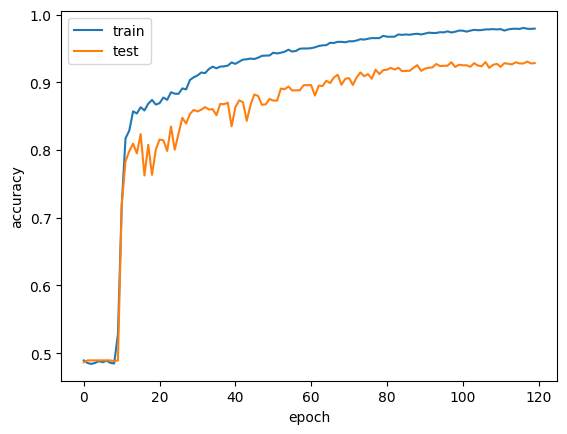

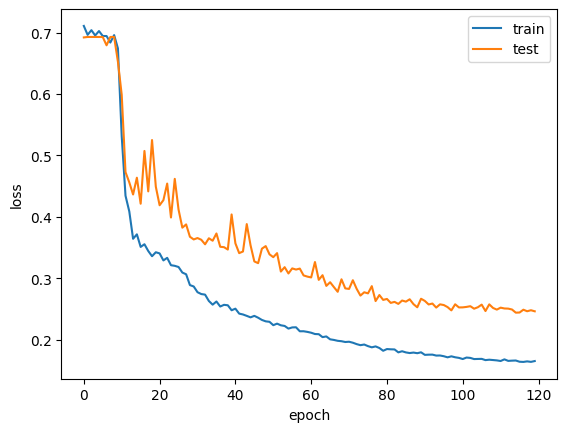

In [17]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [18]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear.csv')

In [19]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.489236,0.486465,0.711149,0.692422
1,0.485410,0.489253,0.696609,0.693147
2,0.484049,0.489253,0.704234,0.693147
3,0.485605,0.489253,0.695605,0.693147
4,0.488134,0.489253,0.702792,0.693147
